# Use the low rank solver to pass the whole data through one solve() step

In [1]:
from moscot.problems.cross_modality import TranslationProblem
from moscot.costs import get_available_costs

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp
import scanpy as sc

import matplotlib.pyplot as plt
import os
import plotnine as p9
import jax
import gc
from sklearn.metrics import r2_score

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
model_path = "/p/project1/hai_fzj_bda/koenig8/ot/models/low_rank"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_histo = adata_histo[adata_histo.obs.in_sample]
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 50156 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample'
     obsm: 'brain_area_onehot', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

### Start with the simple setting: Just the PCA embeddings of both modalities + fuse term

In [7]:
get_available_costs()

{'moscot': ('barcode_distance', 'leaf_distance'),
 'ott': ('euclidean', 'sq_euclidean', 'cosine', 'pnorm_p', 'sq_pnorm')}

In [25]:
tp = TranslationProblem(adata_st, adata_histo)
tp = tp.prepare("pca_embedding", "uni_pca_95", joint_attr="brain_area_onehot")
tp = tp.solve(alpha = 0.75, epsilon = 0, rank = 1000)

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(50000, 50156)].                                        


In [28]:
tp.save(os.path.join(model_path, "fused_standard.pkl"), overwrite = True)

#### Switch to CPU and translate

In [3]:
def switch_to_cpu():
    """Switch JAX to CPU mode."""
    [x.delete() for x in jax.devices()[0].client.live_buffers()]
    gc.collect()
    jax.config.update("jax_default_device", jax.devices("cpu")[0])

def switch_to_gpu():
    """Switch JAX to GPU mode."""
    gc.collect()
    jax.config.update("jax_default_device", jax.devices("gpu")[0])

    
def plot_costs(tp):
    costs = pd.DataFrame({"cost": tp.solutions[('src', 'tgt')]._costs.copy()})
    costs = costs.assign(step = np.arange(len(costs)))
    costs = costs[costs.cost != -1]
    converged=bool(tp.solutions[('src', 'tgt')]._output.converged)
    if converged:
        txt = "converged"
    else:
        txt = "did not converge"
    
    cost_plot = (
        p9.ggplot(costs, p9.aes(x="step", y="cost")) +
        p9.geom_line() +
        p9.labs(title = f"Cost function during training, solver {txt}")
    )
    return cost_plot

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


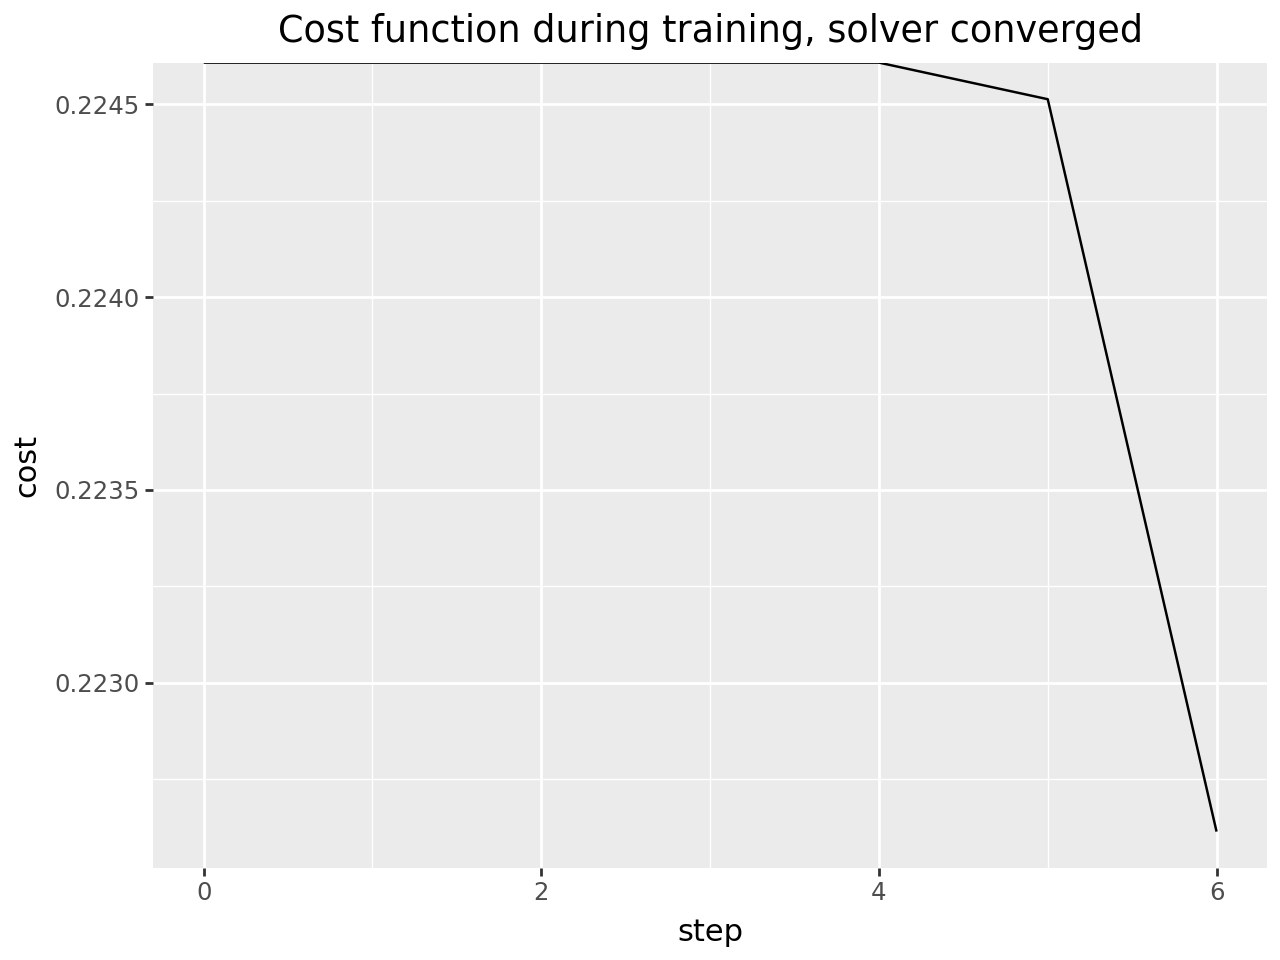

In [29]:
del tp
switch_to_cpu()
tp = TranslationProblem(adata_st, adata_histo).prepare("pca_embedding", "uni_pca_95", joint_attr="brain_area_onehot")
tp = tp.load(os.path.join(model_path, "fused_standard.pkl"))
plot_costs(tp)

In [4]:
def translate_tp(tp, batch_size = 300, adata_target = adata_histo, feature_key = "uni_pca_95"):
    batch_transformed = []
    prop = tp["src", "tgt"]
    features = adata_target.obsm[feature_key]
    
    for i in range(0, features.shape[1], batch_size):
        batch_transformed.append(prop.pull(
            features[:, i:i+batch_size], subset = None, normalize = False, scale_by_marginals = True
        ))
    
    translation = np.concatenate(batch_transformed, axis=1)
    return translation

In [33]:
translation = translate_tp(tp)
translation.shape

(50000, 368)

In [5]:
def translation_metric(tp, adata_src = adata_st, adata_target = adata_histo):
    predictions_T = [] 
    T = tp[('src', 'tgt')].solution.transport_matrix.__array__()
    src_coords = adata_src.obs.loc[:, ("x_st", "y_st", "z_st")]
    target_coords = adata_target.obs.loc[:, ("x_st", "y_st", "z_st")]
    N = src_coords.shape[0]
    
    if np.isnan(T.flatten()).any():
        return -1e6  # Bad performance to indicate sth went wrong in the solution step

    for j in range(N):
        t_j = T[j] / np.sum(T[j])
        t_j = np.repeat(t_j[:, None], 3, axis=1)
        prediction = np.sum(target_coords * t_j, axis = 0)
        predictions_T.append(prediction)
    
    predictions_T = np.vstack(predictions_T)
    
    return r2_score(src_coords, predictions_T)

In [41]:
translation_metric(tp)

-0.599314290719759

==> Very bad performance

In [7]:
def plot_umap(translation, adata_src = adata_st, adata_target = adata_histo, target_key = "uni_pca_95"):
    set1 = set(list(adata_src.obs["brain_area"]))
    set2 = set(list(adata_target.obs["brain_area"]))
    cats = list(set1 | set2)
    cmap = plt.get_cmap("tab20")
    color_map = {cat: cmap(i / len(cats)) for i, cat in enumerate(cats)}
    adata_src.obsm["transformed"] = translation 
    
    adata = sc.concat(
        [adata_src, adata_target],
        join="outer",
        label="batch",
        keys=["ST (translated)", "Histo"],
    )
    adata.obsm["X_translated"] = np.concatenate(
        (adata_src.obsm["transformed"], adata_target.obsm[target_key]), axis=0
    )
    sc.pp.neighbors(adata, use_rep="X_translated")
    sc.tl.umap(adata)
    
    fig_umap, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 9))
    
    sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
    ax1.legend()
    ax1.set_title("Colored based on modality")
    
    sc.pl.umap(adata, color=["brain_area"], ax=ax2, show=False)
    ax2.set_title("Colored based on brain areas")
    
    return fig_umap

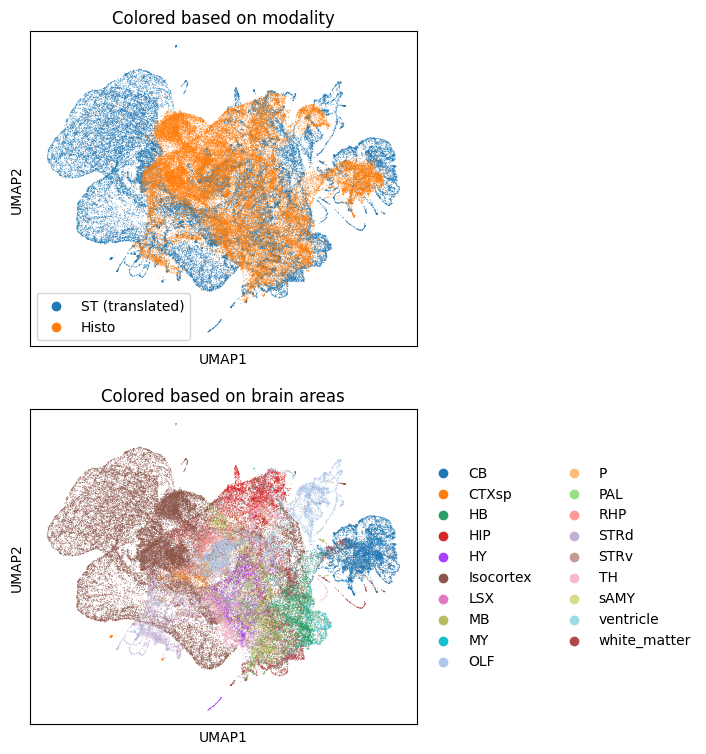

In [43]:
plt.show()

## Try out different ranks

In [8]:
def solve_tp(tp, alpha, epsilon, rank):
    try:
        tp = tp.solve(alpha = alpha, epsilon = epsilon, rank = rank)
        return tp
    except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(e)
                print("======================================FAILURE=========================================")
                return False  # OOM Error
            else:
                raise e  # Some other error
def try_ranks(tp, lowest_rank = 1000, start_rank = 5000, alpha = 0.75, epsilon = 0, best_solution = None):
    print(f"================================= Range {lowest_rank} - {start_rank} ===============================")
    result = solve_tp(tp, alpha, epsilon, start_rank)
    if result:
        # Success, increase rank
        current_rank = int(start_rank * 1.5)
        lowest_rank = start_rank
        best_solution = result
    else:
        # Failed, lower rank
        current_rank = lowest_rank + int((start_rank - lowest_rank)/2)
    if current_rank - lowest_rank < 50:
        return best_solution
    return try_ranks(tp, lowest_rank, current_rank, alpha, epsilon, best_solution)


In [9]:
tp = TranslationProblem(adata_st, adata_histo)
tp = tp.prepare("pca_embedding", "uni_pca_95", joint_attr="brain_area_onehot")
tp = try_ranks(tp)

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
================================= Range 1000 - 5000 ===============================
INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(50000, 50156)].                                        


In [11]:
tp.save(os.path.join(model_path, "rank_5000.pkl"), overwrite = True)